In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install catboost
    !pip install PDPbox
    !pip install shap

In [ ]:
# colab 연결 끊김 방지, F12누르고 콘솔에 아래 코드 입력하기 
function ClickConnect() {var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); buttons.forEach(function(btn) { btn.click(); }); console.log("1분마다 자동 재연결"); document.querySelector("colab-toolbar-button#connect").click(); } setInterval(ClickConnect,1000*60);

In [1]:
# 구글 드라이브 연동
from google.colab import files
upload=files.upload()

Saving Train.csv to Train.csv


In [2]:
import numpy as np
import pandas as pd
import io

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 
#warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

df = pd.read_csv('Train.csv')

In [ ]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()
profile

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


#E-Commerce Shipping Data
이 데이터를 통해서 이번 프로젝트를 준비하려고 한다.




* ID: ID Number of Customers.
* Warehouse block : 회사에는 A,B,C,D,E와 같은 블록으로 나누어진 큰 창고가 있습니다.
*Mode of shipment - 제품을 선박, 비행 및 도로와 같은 다양한 방법으로 배송
*Customer care calls (고객 관리 전화) - 발송물 조회를 위한 문의로 걸려온 전화 수.
*Customer rating (고객 등급) - 모든 고객들로부터 등급을 매겼다. 1이 가장 낮음(worst), 5가 가장 높음(best)입니다.
*Cost of the product: 제품 비용(미국 달러)
*Prior purchases: 이전 구입 횟수
*Product importance: 회사는 제품을 저, 중, 고 등 다양한 파라미터로 분류함
*Gender: 남성과 여성.
*Discount offered: 특정 제품에 대한 할인이 제공
*Weight in gms:그램 단위의 무게


---
#Target 

Reached.on.Time_Y.N 
* 1 : 제품이 제시간에 도달하지 못했음
* 0 :  제시간에 도달했음

# 데이터를 선정한 이유
국내 전자상거래 경쟁시장에서 쿠팡, 마켓컬리이 생기면서 우리나라 배송시스템 문화가 달라졌다. (당일배송, 새벽배송)을 통해 소비자들은 물건을 주문하면 빨리 받을 수 있게 되었다. 이제는 당연히 빨리 받는 것으로 여겨지고 있지만 불과 10년 전만 해도 물건을 주문하면 빠르면 2일이였지만 대부분 며칠 걸리기 때문에 걸려서 제품이 언제 도착하는지에 대한 문의 전화 같은 것들을 남기는 경우가 많았다.
그렇지만 아직까지 국제적 전자상거래 시장에서는 배달이 정해진 시간 내에 도착하지 못했는 경우가 있다. 그중 제가 고른 E-Commerce Shipping Data만 봐도  제품이 제 시간에 도달하지 못한 경우가 더 많다는 것을 확인하였습니다. 제품이 제 시간에 도착했는지 못했는지에 대한 것을 거리, 기후변화 과 같은 것들과 비교한 것이 아닌 제품의 가격, 고객의 전화횟수, 고객의 등급 등과 정보로 관련이 있는지 분류하는 데이터이다. 배송하는데 전혀 관련이 있을까? 싶은 생각이 들었고 어떤 관계가 있을지 흥미가 있어보여서 선정하게 됐습니다.


# 가설

1. customer rating이 높을 수록 제 시간에 도착했을까?
2. customer care calls가 높을 수록 제 시간에 도착했을까?

In [ ]:
df['Reached.on.Time_Y.N'].value_counts()
# 0 : 제 시간에 도착을 했다.
# 1 : 제 시간에 도착하지 못했다

1    6563
0    4436
Name: Reached.on.Time_Y.N, dtype: int64

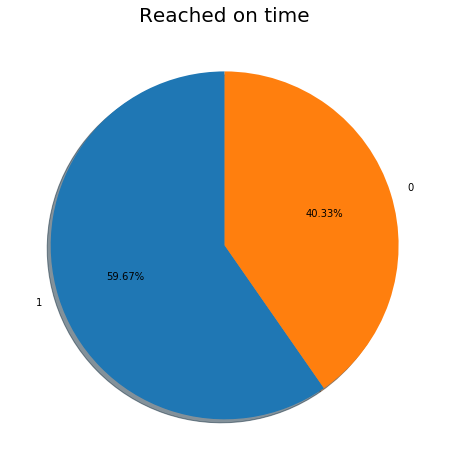

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(df['Reached.on.Time_Y.N'].value_counts(), labels = df['Reached.on.Time_Y.N'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Reached on time', size=20)
plt.show()

# 타겟 변수의 값 분포를 그래프로 표현하였다.
# 제 시간에 도달하지 못한 경우가 더 많다는 것을 알 수 있다.

In [3]:
# 분류 문제 베이스 라인 설정
major = df['Reached.on.Time_Y.N'].mode()[0]
baseline = [major] * len(df)

from sklearn.metrics import accuracy_score
print("훈련 정확도 : ", accuracy_score(df['Reached.on.Time_Y.N'], baseline))
print ('roc_auc_score ', roc_auc_score(df['Reached.on.Time_Y.N'], baseline))

훈련 정확도 :  0.5966906082371125
roc_auc_score  0.5


#Feature Engineering

In [ ]:
df['Product_importance'].value_counts()

low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64

In [ ]:
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 945.4+ KB


In [ ]:
df.columns

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')

In [ ]:
df['Gender']

0        F
1        M
2        M
3        M
4        F
        ..
10994    F
10995    F
10996    F
10997    M
10998    F
Name: Gender, Length: 10999, dtype: object

In [ ]:
df.describe(include=np.object)
# 데이터 타입이 object인 컬럼들을 확인해봤다.

,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999
unique,3,3,2
top,Ship,low,F
freq,7462,5297,5545


In [ ]:
#많이 사용하는 운송 수단은 Ship이며 67.84%를 차지한다.
# 여성 회원들의 비율 50.41%
# 제품의 중요도 중 가장 많이 차지하는 것은 low이며  비율은 48.15%이다.

In [ ]:
df.isnull().sum()
# 결측치가 없다는 것을 확인하였다. 

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [48]:
df.duplicated().value_counts()

False    10999
dtype: int64

In [ ]:
print(df[['Gender','Customer_care_calls']].groupby(['Gender'],as_index = False).mean())
# groupby를 사용하면 기본으로 그룹 라벨이 index가 됩니다.
# index를 사용하고 싶은 않은 경우에는 as_index=False 를 설정하면 됩니다.

# 성별 Customer_care_calls(발송물 조회를 위한 문의로 걸려온 전화 수) 평균값에 대해서 알아보았다.

  Gender  Customer_care_calls
0      F             4.051578
1      M             4.057389


In [ ]:
print(df[['Gender','Customer_rating']].groupby(['Gender'],as_index = False).mean())

# 평균 점수는 2.9 대체적으로 보통 수준의 점수를 매겼다.

  Gender  Customer_rating
0      F         2.986655
1      M         2.994499


In [ ]:
print(df[['Gender','Prior_purchases']].groupby(['Gender'],as_index = False).mean())
# 고객들의 이전 구매 경험 횟수는  평균은 3번이다.

  Gender  Prior_purchases
0      F         3.581785
1      M         3.553172


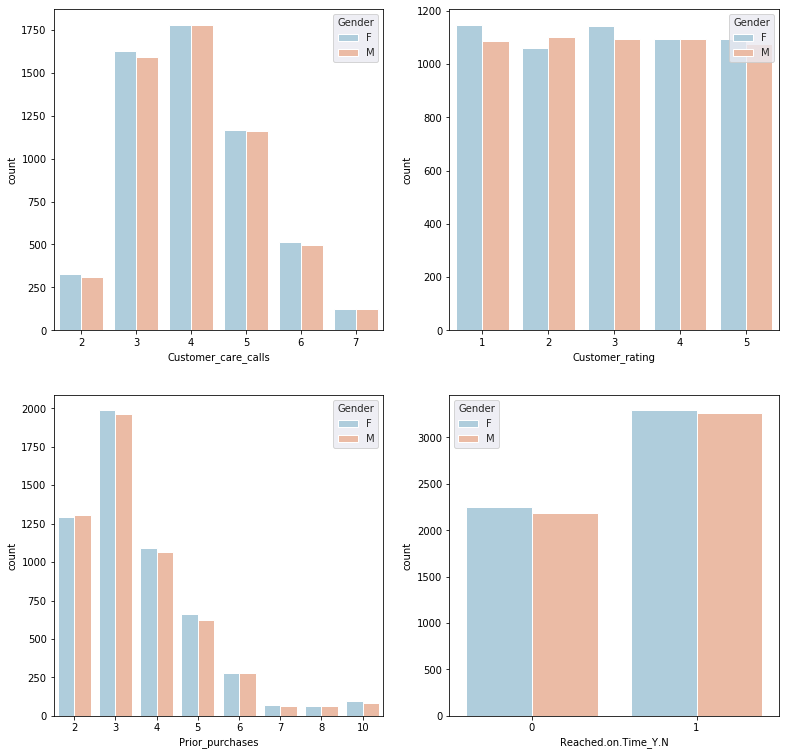

In [ ]:
# 그래프 여러개 그리기

#seaborn에서 스타일링 할 때 크게 두 차원으로 생각해볼 수 있다.
#set_style: background color, grid, spine, tick을 정의하여 그림의 전반적인 모양을 스타일링
#set_context: 프리젠테이션이나 보고서와 같은 다양한 매체에 활용할 수 있도록 스타일링
#Seaborn에는 5가지 기본 제공 테마가 있다. darkgrid, whitegrid, dark, white, ticks. 기본값은 darkgrid이지만, 원하는대로 변경이 가능하다.
fig,axes = plt.subplots(2,2, figsize=(13,13))

sns.set_style('dark')

sns.countplot(data=df, x='Customer_care_calls',hue='Gender',palette='RdBu_r', ax=axes[0,0] )
sns.countplot(data=df, x='Customer_rating',hue='Gender', palette='RdBu_r', ax=axes[0,1])
sns.countplot(data=df, x='Prior_purchases',hue='Gender',palette='RdBu_r',ax=axes[1,0])
sns.countplot(data=df, x='Reached.on.Time_Y.N',hue='Gender',palette='RdBu_r',ax=axes[1,1])



In [ ]:
df['Warehouse_block'].value_counts()
# F 창고가 가장 많이 있다.

F    3666
D    1834
A    1833
C    1833
B    1833
Name: Warehouse_block, dtype: int64

In [ ]:
df['Mode_of_Shipment'].value_counts()

Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64

In [ ]:
df['Customer_care_calls'].value_counts()
# 발송물 조회를 위한 문의로 걸려온 전화 수가 평균이 4건인데 너무 많이 전화를 하는거같다....
# 고객전화를 하기 위한 상담사가 많이 필요로 할 수 도 있고, 통화하기 위한 시간이 많이 소요되는거같다
# 배송이 늦게와서 전화를 계속하는건 아닐까? 생각이 든다.
# 외국 같은 경우 한국에 비해 배송기간이 기본 2일 이상은 걸리니까 급해서 전화를 계속하는 것인가? 


4    3557
3    3217
5    2328
6    1013
2     638
7     246
Name: Customer_care_calls, dtype: int64

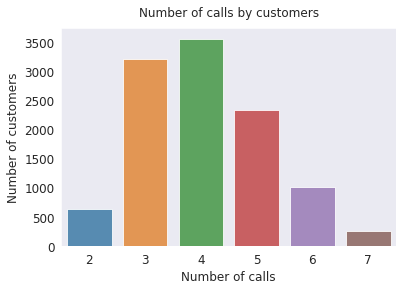

<Figure size 936x864 with 0 Axes>

In [ ]:
call_count = df['Customer_care_calls'].value_counts()

sns.barplot(x=call_count.index, y=call_count, alpha = .8) # alpha 파라미터는  투명도 옵션값이다.
plt.title('Number of calls by customers', fontsize=12, pad=12) #pad 파라미터는 타이틀과 그래프와의 간격
plt.ylabel('Number of customers', fontsize=12) # y 축 이름
plt.xlabel('Number of calls', fontsize=12) # x축 이름
plt.xticks(fontsize=12) #x축 폰트 사이즈 크기 
plt.yticks(fontsize=12) #y축 폰트 사이즈 
plt.figure(figsize=(13, 12)) #전체 그래프 크기
plt.show()

In [ ]:
df['Customer_rating'].value_counts()

3    2239
1    2235
4    2189
5    2171
2    2165
Name: Customer_rating, dtype: int64

In [ ]:
df.sort_values(by = 'Customer_rating') # Customer_rating을 가장 낮은 점수부터 분류하였다.
# 1 : 가장 낮음(worst)
# 5 : 가장 높음(best)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
3374,3375,A,Ship,4,1,157,2,medium,M,3,5801,0
8303,8304,F,Ship,3,1,274,2,high,M,2,4352,0
5453,5454,F,Road,4,1,196,5,low,M,7,5380,0
4009,4010,F,Ship,5,1,185,2,medium,F,10,5973,1
5446,5447,C,Ship,4,1,236,3,low,F,4,4248,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8877,8878,B,Ship,6,5,269,4,medium,F,7,1249,1
4319,4320,F,Ship,3,5,133,3,medium,F,4,5902,0
8880,8881,D,Road,7,5,308,4,medium,M,1,1477,1
8862,8863,D,Ship,4,5,239,5,low,M,6,1336,0


In [4]:
df = df.drop(['Warehouse_block'],axis=1)

In [ ]:
df

,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,Flight,4,2,177,3,low,F,44,1233,1
1,Flight,4,5,216,2,low,M,59,3088,1
2,Flight,2,2,183,4,low,M,48,3374,1
3,Flight,3,3,176,4,medium,M,10,1177,1
4,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...
10994,Ship,4,1,252,5,medium,F,1,1538,1
10995,Ship,4,1,232,5,medium,F,6,1247,0
10996,Ship,5,4,242,5,low,F,4,1155,0
10997,Ship,5,2,223,6,medium,M,2,1210,0


In [ ]:
df.columns

Index(['Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating',
       'Cost_of_the_Product', 'Prior_purchases', 'Product_importance',
       'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N'],
      dtype='object')

데이터를 훈련/테스트 테이터로 분리한다.

In [5]:
from sklearn.model_selection import train_test_split

# train / val / test split
target='Reached.on.Time_Y.N'
features = df.drop(columns = target).columns

train, test = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df[target])
train, val = train_test_split(train, test_size = 0.2, random_state = 42, stratify = train[target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7039, 10), (7039,), (1760, 10), (1760,), (2200, 10), (2200,))

In [ ]:
df

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0


분류 모델의 성능 평가 지표를 보여주는 Confusion matrix

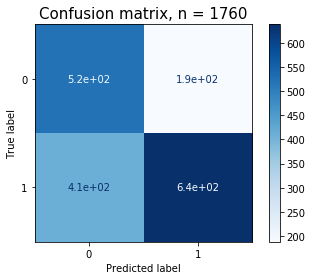

In [7]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [8]:
cm = pcm.confusion_matrix
correct_predictions = np.diag(cm).sum() #정확하게 맞춘 예측의 수 (TP + TN)
total_predictions = cm.sum() #총 예측한 수
correct_predictions/total_predictions # 분류 정확도 계산
print('검증 정확도: ', accuracy_score(y_val, y_pred))

#분류기의 정확한 성능을 판단하기 위해서는 정확도 외에 다른 평가지표를 같이 사용한다.

검증 정확도:  0.6590909090909091


# ROC, AUC

In [9]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.2, 0.7, 1. , ..., 1. , 1. , 1. ])

In [10]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.0
1,0.000000,0.465714,1.0
2,0.009859,0.471429,0.9
3,0.043662,0.493333,0.8
4,0.121127,0.540000,0.7
5,0.264789,0.607619,0.6
6,0.477465,0.712381,0.5
7,0.678873,0.840000,0.4
8,0.842254,0.922857,0.3
9,0.946479,0.982857,0.2


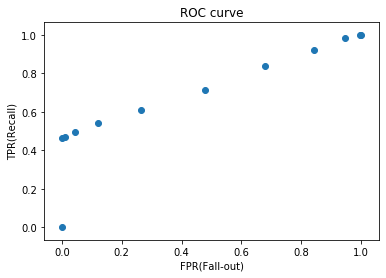

In [11]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [12]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 1 , threshold: 1.0


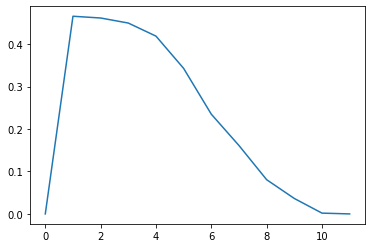

In [13]:
plt.plot(tpr-fpr);

In [14]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       710
           1       1.00      0.47      0.64      1050

    accuracy                           0.68      1760
   macro avg       0.78      0.73      0.68      1760
weighted avg       0.82      0.68      0.67      1760



In [15]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.7364621059691482

#Random Forest

In [16]:
from scipy.stats import uniform, randint
pipe = Pipeline([
                 ('preprocessing', TargetEncoder()),
                 ('rf', RandomForestClassifier(
                                      random_state = 42,
                                      class_weight='balanced',
                                      n_jobs = -1))])

dists = {  'preprocessing__smoothing': [2.,20.,50.,60.,100.,500.,1000.], 
            'preprocessing__min_samples_leaf': randint(1, 10),
            'rf__n_estimators': randint(50,500), 
            'rf__max_depth' : randint(3,10),
            'rf__min_samples_split' : randint(3,20),
            'rf__min_samples_leaf': randint(3,20),
            }


clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.9min finished


In [17]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'preprocessing__min_samples_leaf': 4, 'preprocessing__smoothing': 60.0, 'rf__max_depth': 6, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 5, 'rf__n_estimators': 391}
MAE:  -0.6917189938410914


In [18]:
model = clf.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print ('accuracy socre', accuracy_score(y_val, y_pred_val))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val))

accuracy socre 0.6823863636363636
roc_auc_score  0.7335814889336016


#XGBClassifier

In [ ]:
pipe2 = Pipeline([ ('preprocessing', TargetEncoder()),
                 ('xgb', XGBClassifier(eval_metric = 'auc', # auc
                                      random_state = 42,
                                      objective = 'binary:logistic',
                                      n_jobs = -1))])

param2 = {   
            'xgb__n_estimators': randint(100,1000), 
            'xgb__learning_rate': uniform(0.01,1),
            'xgb__max_depth' : randint(3,10),
            'xgb__sub_sample' : uniform(0.01,1),
            'xgb__scale_pos_weight' : uniform(0.1,1)}


clf2 = RandomizedSearchCV(
    pipe2, 
    param_distributions=param2, 
    n_iter=50, 
    cv=3, 
    verbose=1,
    n_jobs=-1
)

clf2.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.2min finished


In [ ]:
print('Best Parameter :', clf2.best_params_)
print('Best Score : ', (clf2.best_score_))

Best Parameter : {'xgb__learning_rate': 0.023412248820674823, 'xgb__max_depth': 9, 'xgb__n_estimators': 849, 'xgb__scale_pos_weight': 0.2929182070356037, 'xgb__sub_sample': 0.6529656475679806}
Best Score :  0.6792178027296703


In [ ]:
model2 = clf2.best_estimator_
y_pred_train = model2.predict(X_train)
y_pred_val2 = model2.predict(X_val)


print ('accuracy socre', accuracy_score(y_val, y_pred_val2))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val2))

accuracy socre 0.6852272727272727
roc_auc_score  0.7293494299128103


#LightGBM

In [ ]:
pipe4 = Pipeline([
                 ('preprocessing', TargetEncoder()),
                 ('lgbm', LGBMClassifier(
                                      random_state = 42, 
                                      objective = 'binary', # 'binary' 로 하면 분류 모델 만들 때 사용가능 / 'regression'으로 바꾸면 회귀 모델 만들 떄 사용
                                      eval_metric = 'auc',
                                      n_jobs = -1))])

param4 = {  'preprocessing__smoothing': [2.,20.,50.,60.,100.,500.,1000.], 
            'preprocessing__min_samples_leaf': randint(1, 10),
            'lgbm__n_estimators': randint(50,500), # 기본값이 100이며 1000정도는 해주는게 좋다. 근데 너무 크게하면 과적합이 발생할 수 있다.
            'lgbm__learning_rate': uniform(0.01,0.1), # 일반적으로 0.01~0.1정도로 맞추고 다른 파라미터를 튜닝한다. 나중에 성능을 더 높일 때 더 줄여준다.
            'lgbm__max_depth' : randint(3,10), # 파라미터 설정 시 우선적으로 설정한다. -1로 설정하면 제한없이 분기한다.
            'lgbm__boosting' : ['gbdt','rf','dart','gos s'],
            'lgbm__colsample_bytree': uniform(0.1,1)}


clf4 = RandomizedSearchCV(
    pipe4, 
    param_distributions=param4, 
    n_iter=50, 
    cv=3, ㅎ
    verbose=1,
    n_jobs=-1
)

clf4.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   57.9s finished


In [ ]:
print('Best Parameter :', clf4.best_params_)
print('Best Score : ', (clf4.best_score_))

Best Parameter : {'lgbm__boosting': 'gbdt', 'lgbm__colsample_bytree': 0.5207696646682278, 'lgbm__learning_rate': 0.021857095937077346, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 197, 'preprocessing__min_samples_leaf': 5, 'preprocessing__smoothing': 1000.0}
Best Score :  0.6870302223258656


In [ ]:
model4 = clf4.best_estimator_
y_pred_train4 = model4.predict(X_train)
y_pred_val4 = model4.predict(X_val)

print ('accuracy socre', accuracy_score(y_val, y_pred_val4))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val4))

accuracy socre 0.6829545454545455
roc_auc_score  0.728128772635815


#RamdomForest의 성능이 가장 좋게 나타났다.

훈련 정확도 :  0.5966906082371125

roc_auc_score  0.5

accuracy socre 0.6823863636363636

roc_auc_score  0.7335814889336016

In [19]:
model = clf.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print ('accuracy socre', accuracy_score(y_val, y_pred_val))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val))

accuracy socre 0.6823863636363636
roc_auc_score  0.7335814889336016


In [ ]:
from sklearn.linear_model import Ridge
# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=20),
    Ridge(alpha=1.0)
)

# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)

MAE (3 folds): [nan nan nan]


In [ ]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    # TargetEncoder: 범주형 변수 인코더로, 타겟값을 특성의 범주별로 평균내어 그 값으로 인코딩
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [0.35615543 0.35068171 0.34213314]


In [ ]:
-scores.mean()

0.3496567605055814

In [ ]:
scores.std()

0.005770273043644441

In [ ]:
X_train.describe(exclude='number')

,Mode_of_Shipment,Product_importance,Gender
count,7039,7039,7039
unique,3,3,2
top,Ship,low,F
freq,4810,3355,3579


In [ ]:
enc = TargetEncoder(min_samples_leaf=1, smoothing=1000) 
enc.fit_transform(X_train,y_train)['Product_importance'].value_counts()

0.600752    3355
0.584632    3063
0.622291     621
Name: Product_importance, dtype: int64

In [20]:
X_train['Product_importance'].value_counts()

low       3355
medium    3063
high       621
Name: Product_importance, dtype: int64

In [21]:
from sklearn.metrics import classification_report
# train 학습, 검증셋 정확도
pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

print(classification_report(y_val, pipe.predict(X_val)))

검증 정확도 0.6755681818181818
              precision    recall  f1-score   support

           0       0.58      0.75      0.65       710
           1       0.79      0.63      0.70      1050

    accuracy                           0.68      1760
   macro avg       0.68      0.69      0.67      1760
weighted avg       0.70      0.68      0.68      1760



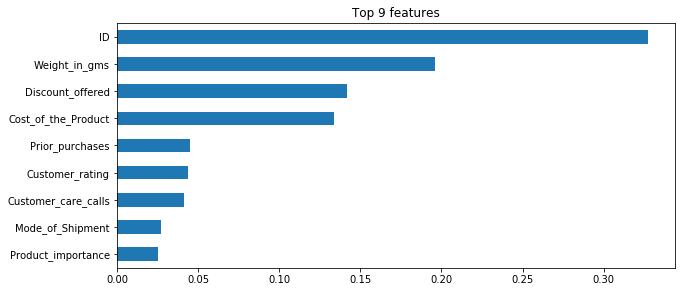

In [32]:
from sklearn.ensemble import RandomForestClassifier
# 특성 중요도
rf = pipe.named_steps['rf']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 9
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

# RandomForest 의 성능이 가장 좋아서 해당 모델에 test 데이터를 적용하였다.


In [33]:
model = clf.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print ('accuracy socre', accuracy_score(y_test, y_pred_test))
print ('roc_auc_score ', roc_auc_score(y_test, y_pred_test))


accuracy socre 0.6809090909090909
roc_auc_score  0.7326732673267327


#SHAP 
만드는거 실패...


In [ ]:
pipe

In [ ]:
enc = TargetEncoder(min_samples_leaf=1, smoothing=1000) 

In [ ]:
X_target_encoded = enc.fit_transform(X_val, y_val)
row = X_target_encoded.iloc[:100]
row

In [ ]:
row_one = X_target_encoded.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row_one

In [ ]:
y_test.iloc[[1]]

In [ ]:
best_pipe = clf.best_estimator_
best_pipe

In [ ]:
# 모델 예측값
best_pipe.predict(row_one)

In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row_one)


shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row_one
)

#PDP

In [34]:
df

,ID,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,Flight,4,2,177,3,low,F,44,1233,1
1,2,Flight,4,5,216,2,low,M,59,3088,1
2,3,Flight,2,2,183,4,low,M,48,3374,1
3,4,Flight,3,3,176,4,medium,M,10,1177,1
4,5,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,Ship,5,2,223,6,medium,M,2,1210,0


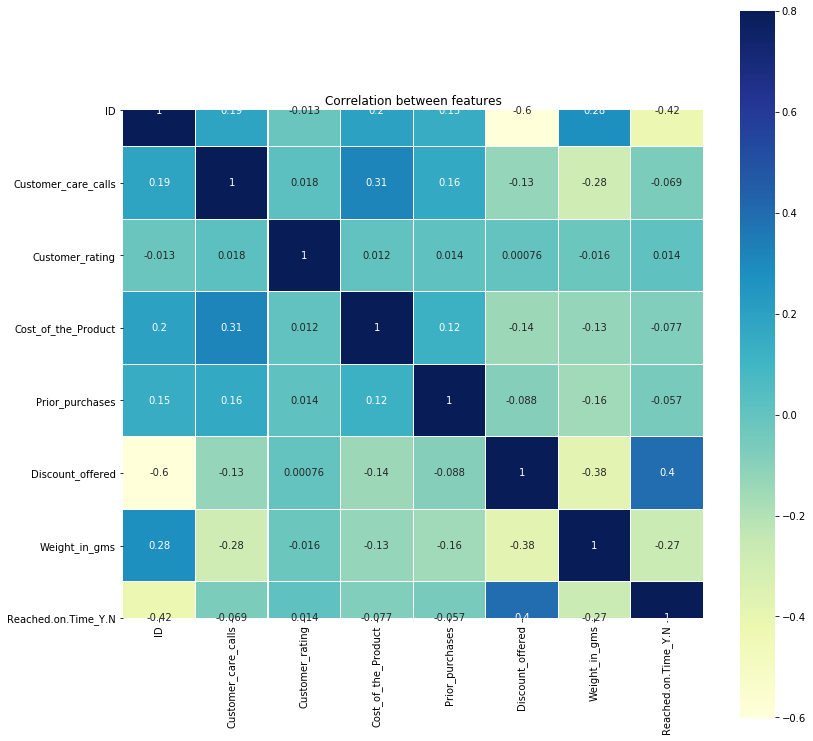

In [35]:
corr=train.corr()
plt.figure(figsize=(13, 13))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [39]:
model.fit(X_train, y_train)
encoder = model.named_steps['preprocessing']
X_test_en = model.named_steps['preprocessing'].transform(X_val)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


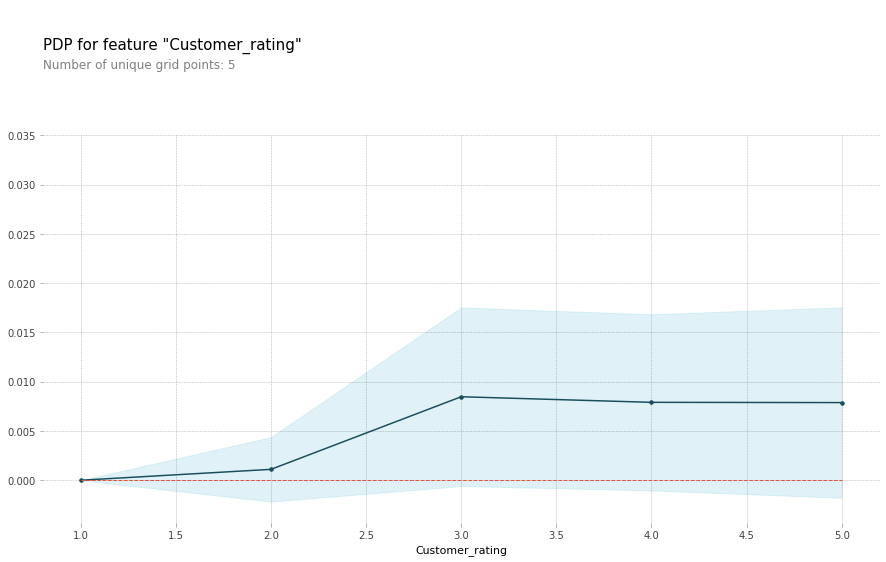

In [40]:
feature = 'Customer_rating'
features = X_test_en.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test_en, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);
# 가설로 세웠던 것 중에 하나인 고객평가 등급이 높을 수록 제품이 제 시간에 도착하는지에 대한 것을 확인해본 결과 고객평가 등급이 3점을 넘어서면서 배송이 제 시간에 도착하는 것에 영향을 미친다는 것을 확인했습니다.


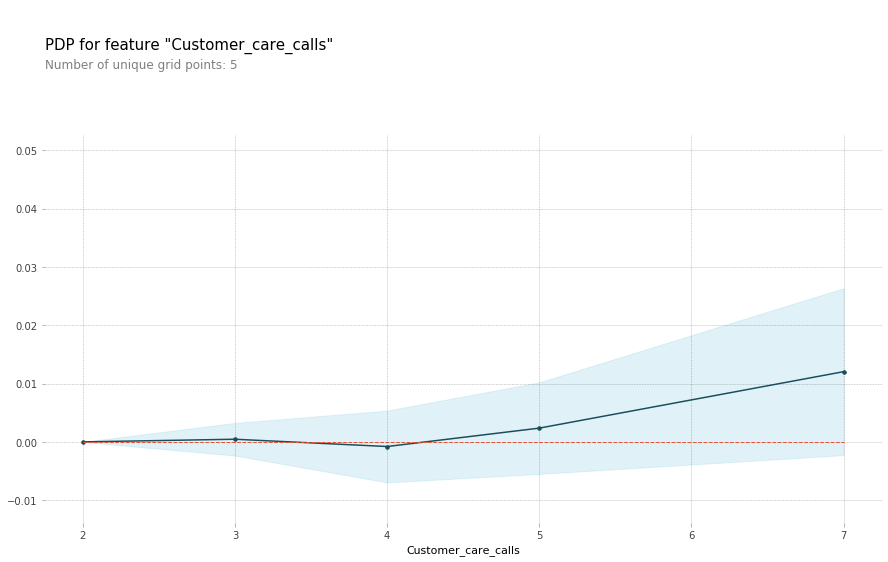

In [41]:
feature = 'Customer_care_calls'
features = X_test_en.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test_en, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

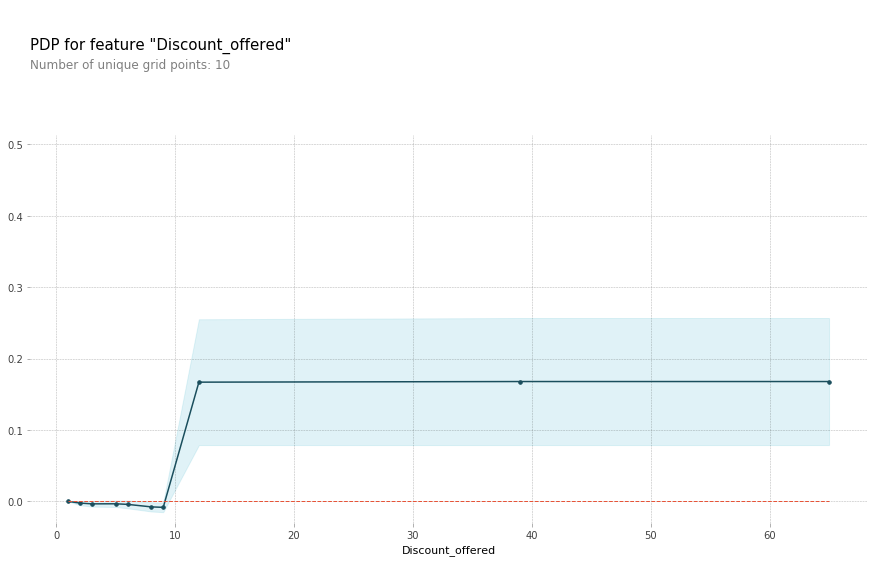

In [42]:
feature = 'Discount_offered'
features = X_test_en.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test_en, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);
# 그래서 모델의 예측 결과에 영향을 미치는지 알아볼 수 있는 PDP plot으로 discount_offered를 지정하여 도출해봤습니다.
# 제공되는 할인이 10를 넘어가면 배송이 제시간에 오는데 영향을 미친다는 결과를 도출했지만 이에 대한 자세한 설명을 할 수 있는 데이터가 없어서 정확하게 왜 이런 결과가 나왔는지 파악을 할 수 없었습니다.


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f36de5916d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f36dee233d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


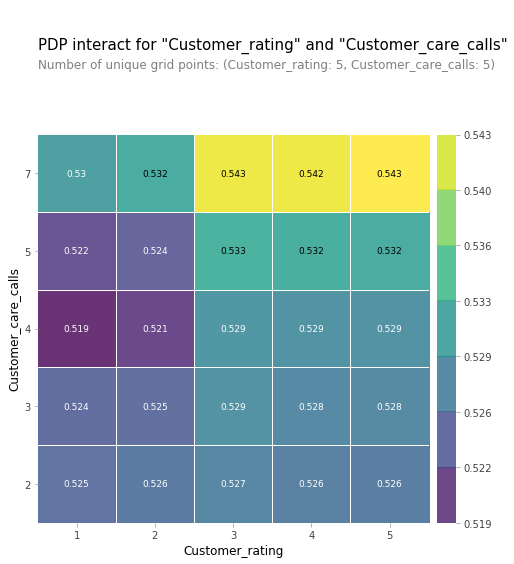

In [43]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Customer_rating', 'Customer_care_calls']
interaction = pdp_interact(
    model=model, 
    dataset=X_test_en, 
    model_features=X_test_en.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
#가설을 세웠을 때 고객의 문의전화를 많이 할 수록 전자상거래 입장에서는 번거롭게 하기 때문에 고객 평가 등급을 낮게 평가할 것이라고 생각하였지만 PDP 를 통해 알게 된 사실은 문의전화를 많이하면 전자상거래 입장에서는  번거로울 수 있지만 고객평가등급이 평균 이상을 차지하는 것을 큰 영향을 미치지 않는 다는 것을 확인하였습니다.


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f36dd422850>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f36deebaad0>})

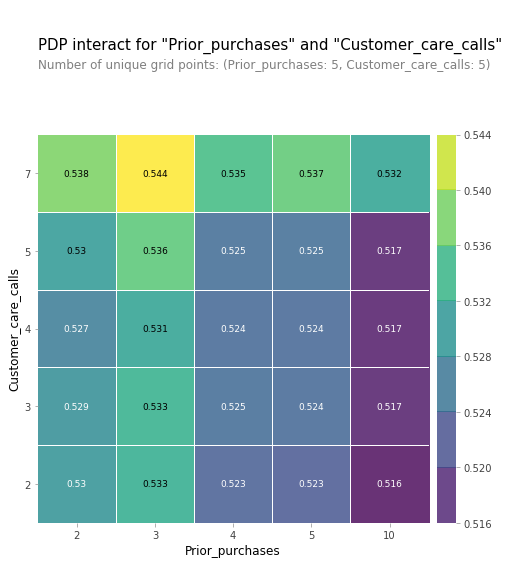

In [44]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Prior_purchases', 'Customer_care_calls']
interaction = pdp_interact(
    model=model, 
    dataset=X_test_en, 
    model_features=X_test_en.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features) 
# 고객이 이전에 구매경험이 있으면 배송 관련 문의 전화 횟수가 적다는 것을 확인하였습니다. 반대로 구매 경험이 적을 수록 문의 전화가 많다는 것입니다.

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f36dcf2b950>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f36dd381a10>})

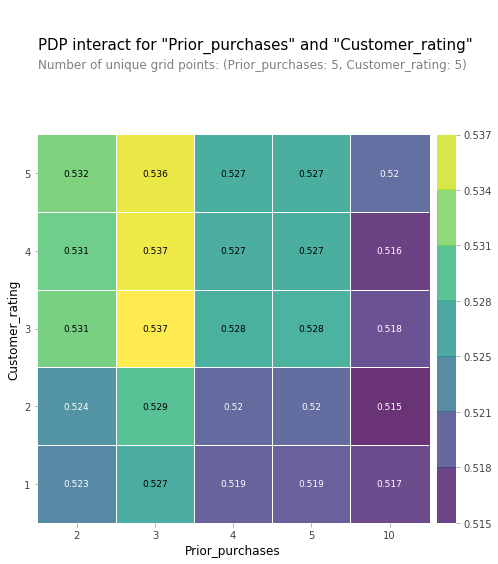

In [50]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Prior_purchases', 'Customer_rating']
interaction = pdp_interact(
    model=model, 
    dataset=X_test_en, 
    model_features=X_test_en.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
# 구매 경험이 많으면 고객평가 등급이 높을지 궁금해서 알아본 결과 그렇지 않다는 것을 확인했습니다.구매경험이 10인 것보다 3이였을 때 고객 평가 등급이 더 높다는 것을 알 수 있습니다.


In [ ]:
df.corr()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
Customer_care_calls,1.000000,0.012209,0.323182,0.180771,-0.130750,-0.276615,-0.067126
Customer_rating,0.012209,1.000000,0.009270,0.013179,-0.003124,-0.001897,0.013119
Cost_of_the_Product,0.323182,0.009270,1.000000,0.123676,-0.138312,-0.132604,-0.073587
Prior_purchases,0.180771,0.013179,0.123676,1.000000,-0.082769,-0.168213,-0.055515
Discount_offered,-0.130750,-0.003124,-0.138312,-0.082769,1.000000,-0.376067,0.397108
Weight_in_gms,-0.276615,-0.001897,-0.132604,-0.168213,-0.376067,1.000000,-0.268793
Reached.on.Time_Y.N,-0.067126,0.013119,-0.073587,-0.055515,0.397108,-0.268793,1.000000


#결론

- customer_rating이 높을 수록 배송이 제 시간에 도착하는데 긍정적인 영향을 미친다.
- customer_care_calls를 많이 할 수록 배송이 제 시간에 도착하는데 긍정적인 영향을 미친다.
- customer_rating은 prior_purchases, customer_care_calls와 연관성이 크지 않다.
고객평가등급이 어떤 요인에 영향을 받아 평가되는지 알 수가 없다.